### Prepare Dataset

In [17]:
from IPython.display import HTML, clear_output

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!unzip /content/drive/MyDrive/Paper_Plastic.zip
clear_output()

In [20]:
import os
# Directory with our training paper pictures
train_paper_dir = os.path.join('/content/train/Paper')

# Directory with our training plastic pictures
train_plastic_dir = os.path.join('/content/train/Plastic_Bag')

# Directory with our validation paper pictures
valid_paper_dir = os.path.join('/content/test/Paper')

# Directory with our validation plastic pictures
valid_plastic_dir = os.path.join('/content/test/Plastic_Bag')

In [21]:
train_paper_names = os.listdir(train_paper_dir)
print(train_paper_names[:10])

train_plastic_names = os.listdir(train_plastic_dir)
print(train_plastic_names[:10])

validation_paper_hames = os.listdir(valid_paper_dir)
print(validation_paper_hames[:10])

validation_plastic_names = os.listdir(valid_plastic_dir)
print(validation_plastic_names[:10])

['paper11.jpgflipped.jpgflipped_bottom.jpg', 'paper415.jpg', 'paper274.jpgflipped_bottom.jpg', 'paper406.jpgflipped_bottom.jpg', 'paper348.jpgflipped.jpgtranspose.jpg', 'paper171.jpg', 'paper253.jpgflipped.jpgtranspose.jpg', 'paper353.jpgflipped_bottom.jpg', 'paper40.jpgtranspose.jpg', 'paper82.jpgtranspose.jpg']
['00000018.jpgflipped.jpgtransverse.jpg', '00000104.jpgtranspose.jpg', '00000007.jpgflipped_bottom.jpgtranspose.jpgtransverse.jpgrotated_90.jpg', '00000015.jpgtranspose.jpgrotated_90.jpg', '00000000.jpgtranspose.jpgtransverse.jpg', '00000008.jpgflipped_bottom.jpgrotated_90.jpg', '00000531.jpgtransverse.jpg', '00000072.jpgflipped.jpgtranspose.jpgrotated_90.jpg', '00000101.jpgflipped.jpgflipped_bottom.jpgtransverse.jpgrotated_90.jpg', '00000000.jpgflipped.jpgtranspose.jpg']
['paper577.jpg', 'paper551.jpg', 'paper571.jpg', 'paper536.jpg', 'paper555.jpg', 'paper531.jpg', 'paper560.jpg', 'paper545.jpg', 'paper559.jpg', 'paper578.jpg']
['00000165.jpgflipped_bottom.jpgtransverse.jpg'

In [22]:
print('total training paper images:', len(os.listdir(train_paper_dir)))
print('total training plastic bag images:', len(os.listdir(train_plastic_dir)))
print('total validation paper images:', len(os.listdir(valid_paper_dir)))
print('total validation plastic bag images:', len(os.listdir(valid_plastic_dir)))

total training paper images: 4384
total training plastic bag images: 2640
total validation paper images: 50
total validation plastic bag images: 160


In [55]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

In [56]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "grey",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

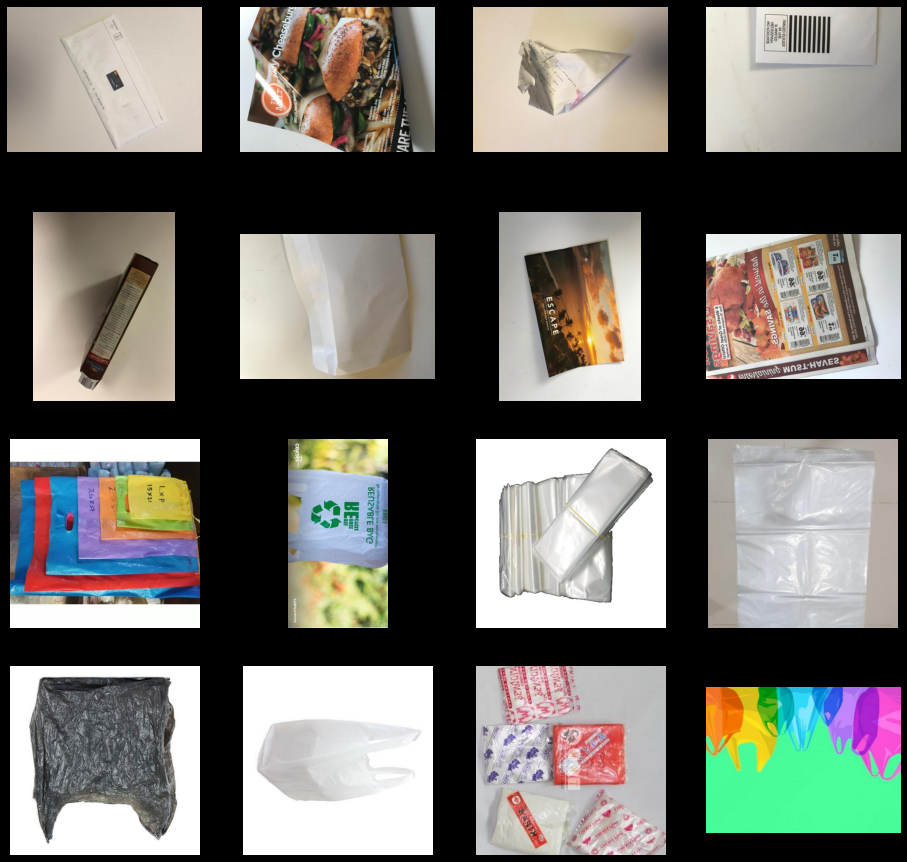

In [25]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_paper_pic = [os.path.join(train_paper_dir, fname) 
                for fname in train_paper_names[pic_index-8:pic_index]]
next_plastic_pic = [os.path.join(train_plastic_dir, fname) 
                for fname in train_plastic_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_paper_pic + next_plastic_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=False,
                                   fill_mode='nearest'
                                   )

validation_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=False,
                                   fill_mode='nearest'
                                   )

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/train',  # This is the source directory for training images
        classes = ['Paper', 'Plastic_Bag'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=120,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/test',  # This is the source directory for training images
        classes = ['Paper', 'Plastic_Bag'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=19,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 7024 images belonging to 2 classes.
Found 210 images belonging to 2 classes.


### Import Libraries

In [64]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential

In [81]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [82]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 23, 23, 128)     

In [83]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [85]:
history = model.fit(train_generator,
      steps_per_epoch=6,  
      epochs=100,
      verbose=1,
      batch_size=32,
      validation_data = validation_generator,
      validation_steps=6)

Epoch 1/100
6/6 [==============================] - 14s 2s/step - loss: 0.6946 - accuracy: 0.5917 - val_loss: 0.6531 - val_accuracy: 0.5614
Epoch 2/100
6/6 [==============================] - 12s 2s/step - loss: 0.6082 - accuracy: 0.7069 - val_loss: 0.5707 - val_accuracy: 0.6140
Epoch 3/100
6/6 [==============================] - 12s 2s/step - loss: 0.5507 - accuracy: 0.7361 - val_loss: 0.4839 - val_accuracy: 0.7105
Epoch 4/100
6/6 [==============================] - 12s 2s/step - loss: 0.4290 - accuracy: 0.8042 - val_loss: 0.4628 - val_accuracy: 0.7193
Epoch 5/100
6/6 [==============================] - 12s 2s/step - loss: 0.3794 - accuracy: 0.8417 - val_loss: 0.9609 - val_accuracy: 0.7018
Epoch 6/100
6/6 [==============================] - 12s 2s/step - loss: 0.4156 - accuracy: 0.8102 - val_loss: 0.3815 - val_accuracy: 0.8596
Epoch 7/100
6/6 [==============================] - 12s 2s/step - loss: 0.4176 - accuracy: 0.8056 - val_loss: 0.4433 - val_accuracy: 0.7982
Epoch 8/100
6/6 [==========

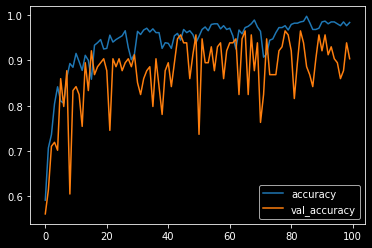

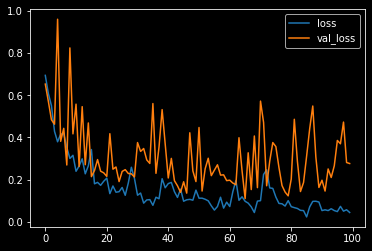

In [86]:
import pandas as pd

evaluation = pd.DataFrame(model.history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()

In [87]:
model.evaluate(validation_generator)

12/12 [==============================] - 3s 254ms/step - loss: 0.3052 - accuracy: 0.9048


[0.30518898367881775, 0.9047619104385376]

In [88]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

12/12 [==============================] - 3s 250ms/step


In [89]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [90]:
roc_auc = auc(fpr, tpr)

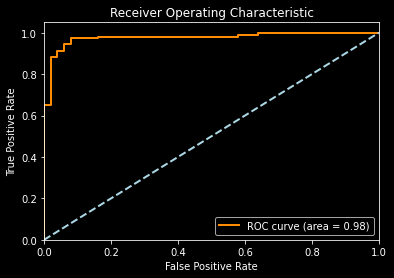

In [93]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightblue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [94]:
model.save('model.h5')

Saving 00000209.jpg to 00000209.jpg
[1.]
00000209.jpg ini adalah plastik


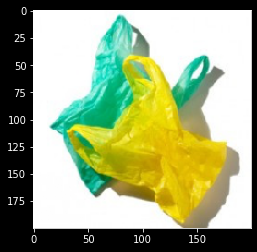

In [103]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(200, 200))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " ini adalah kertas")
  else:
    print(fn + " ini adalah plastik")